<a href="https://colab.research.google.com/github/MuhammadHanif9/EcodeCamp_Task_Two/blob/main/Hand_Gesture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile

# Create the Kaggle directory and move kaggle.json there
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/

# Set the permission for the kaggle.json file
!chmod 600 /root/.kaggle/kaggle.json

# Verify Kaggle API is set up correctly
!kaggle datasets list

# Download the dataset using Kaggle API
!kaggle datasets download -d aryarishabh/hand-gesture-recognition-dataset

# Unzip the dataset if it's a zip file
with zipfile.ZipFile('hand-gesture-recognition-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/hand-gesture-recognition-dataset')


ref                                                                  title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
haseebindata/student-performance-predictions                         Student Performance Predictions                  9KB  2024-08-17 06:57:57           5133        111  0.9411765        
uom190346a/sleep-and-health-metrics                                  Sleep and Health Metrics                        73KB  2024-08-31 02:39:09            832         26  1.0              
berkayalan/paris-2024-olympics-medals                                Paris 2024 Olympics Medals                       1KB  2024-08-14 11:02:45           4811         89  1.0              
jeannicolasduval/2024-fortune-1000-companies                

In [2]:
print(os.listdir('/content/hand-gesture-recognition-dataset'))

['test', 'train']


In [18]:
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [19]:
dataset_dir = 'hand-gesture-recognition-dataset'
image_files = []
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith('.png') or file.endswith('.jpg'):
            image_files.append(os.path.join(root, file))

print(f"Found {len(image_files)} images in the dataset.")

Found 24000 images in the dataset.


In [20]:

# Resize dimensions
img_size = 64

# Placeholder for images and labels
X = []
y = []

# Load and preprocess each image
for image_file in image_files:
    # Read the image
    img = cv2.imread(image_file)

    # Resize the image
    img = cv2.resize(img, (img_size, img_size))

    # Normalize the image
    img = img.astype('float32') / 255.0

    # Append the preprocessed image to the list
    X.append(img)

    # Extract label from the directory structure or filename
    label = os.path.basename(os.path.dirname(image_file))  # Assuming labels are directory names
    y.append(label)

# Convert lists to numpy arrays
X = np.array(X)




In [21]:
# Encode labels if necessary
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y)

print(f"Processed {X.shape[0]} images with shape {X.shape[1:]} and {len(label_encoder.classes_)} classes.")

Processed 24000 images with shape (64, 64, 3) and 20 classes.


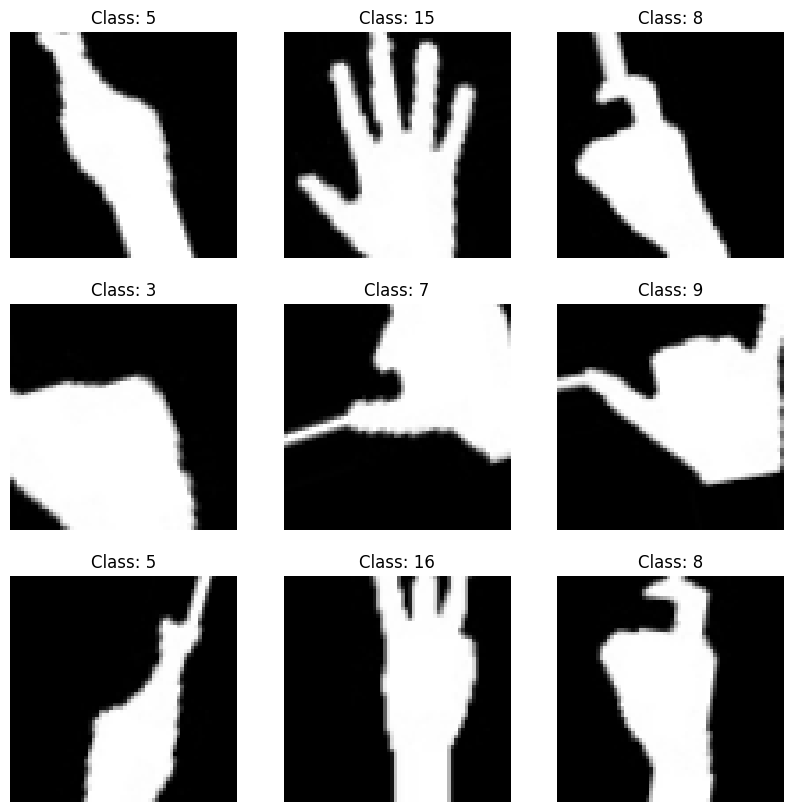

In [22]:


# Create an ImageDataGenerator object for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator to your data (if needed)
datagen.fit(X)

# Example: Generating one batch of augmented images
augmented_images, augmented_labels = next(datagen.flow(X, y, batch_size=32))

# To visualize some augmented images:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.title(f"Class: {np.argmax(augmented_labels[i])}")
    plt.axis('off')
plt.show()


In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

# Define the CNN model
def create_cnn_model(input_shape, num_classes):
    model = Sequential()

    # Use Input layer to define the input shape
    model.add(Input(shape=input_shape))

    # Now add the rest of the layers
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Input shape: (64, 64, 3) for 64x64 RGB images, and num_classes is the number of gesture classes
input_shape = (64, 64, 3)
num_classes = len(label_encoder.classes_)  # Assuming `label_encoder` was created in the preprocessing step

cnn_model = create_cnn_model(input_shape, num_classes)

# Print the model summary
cnn_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 6, 6, 128)        

In [25]:
# Train the model
history = cnn_model.fit(X, y, epochs=15, batch_size=32, validation_split=0.2)

# Save the model
cnn_model.save('cnn_hand_gesture_model.keras')


Epoch 1/15
600/600 [==============================] - 4s 7ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0447 - val_accuracy: 0.9952
Epoch 2/15
600/600 [==============================] - 4s 7ms/step - loss: 4.3665e-04 - accuracy: 0.9998 - val_loss: 0.0575 - val_accuracy: 0.9954
Epoch 3/15
600/600 [==============================] - 4s 7ms/step - loss: 5.0507e-04 - accuracy: 0.9998 - val_loss: 0.0419 - val_accuracy: 0.9969
Epoch 4/15
600/600 [==============================] - 4s 6ms/step - loss: 0.0010 - accuracy: 0.9997 - val_loss: 0.0469 - val_accuracy: 0.9969
Epoch 5/15
600/600 [==============================] - 4s 6ms/step - loss: 0.0051 - accuracy: 0.9988 - val_loss: 0.0595 - val_accuracy: 0.9958
Epoch 6/15
600/600 [==============================] - 5s 8ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.0696 - val_accuracy: 0.9956
Epoch 7/15
600/600 [==============================] - 4s 6ms/step - loss: 2.2064e-04 - accuracy: 0.9999 - val_loss: 0.0559 - val_accuracy: 0